# Image Classification

# Phase 1: EDA & Data Exploration with Visual Insights

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
sns.set(style="whitegrid")

In [2]:
data_path = "/kaggle/input/kidney-stone-classification-and-object-detection"
classes = os.listdir(data_path)

image_count = {cls: len(os.listdir(os.path.join(data_path, cls))) for cls in classes}

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


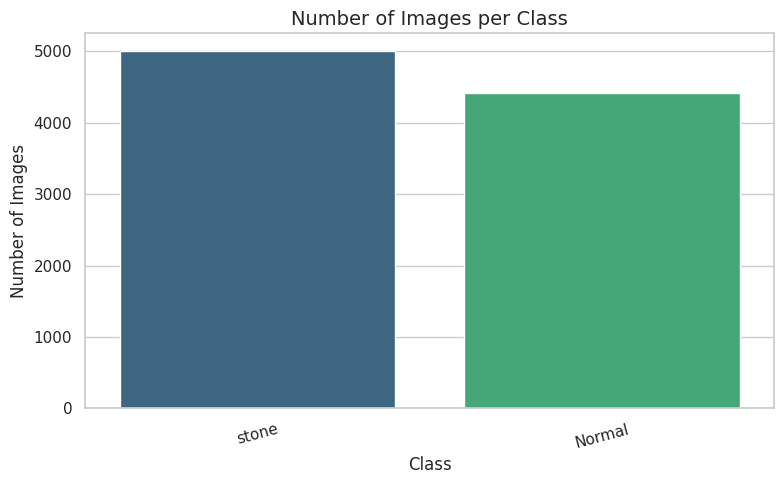

In [3]:
# Visualize number of images per class
plt.figure(figsize=(8, 5))
sns.barplot(x=list(image_count.keys()), y=list(image_count.values()), palette="viridis")
plt.title("Number of Images per Class", fontsize=14)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

This bar plot shows the distribution of the dataset across the two classes: Normal and Stone. It helps us understand whether the dataset is balanced or imbalanced, which is important for choosing the right training strategies. For example, if some classes have significantly fewer samples, we might need to apply data augmentation or use class weighting to avoid biased model training.

# Show Sample Images from Each Class

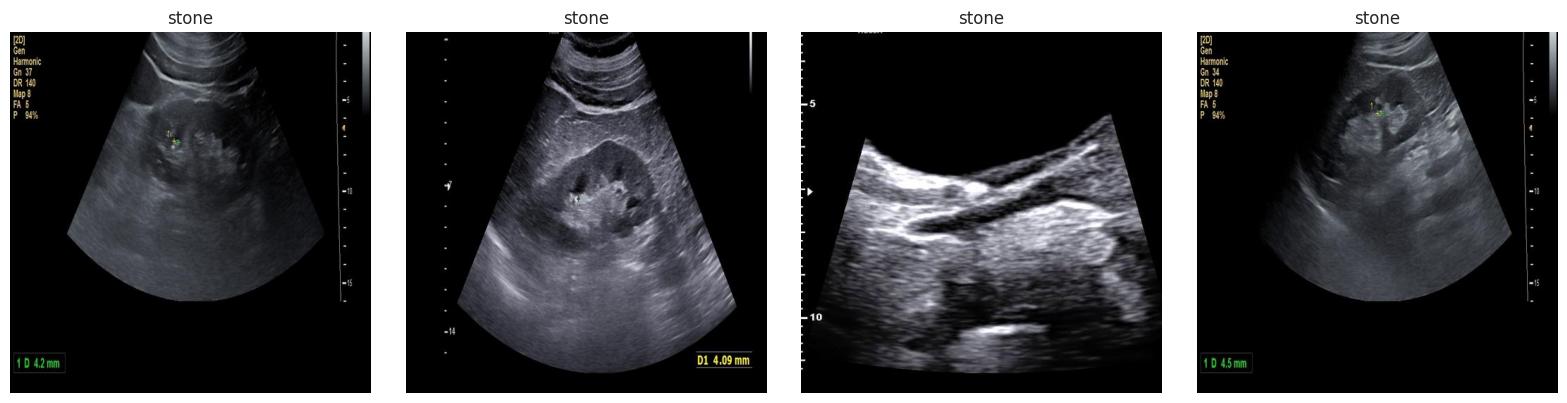

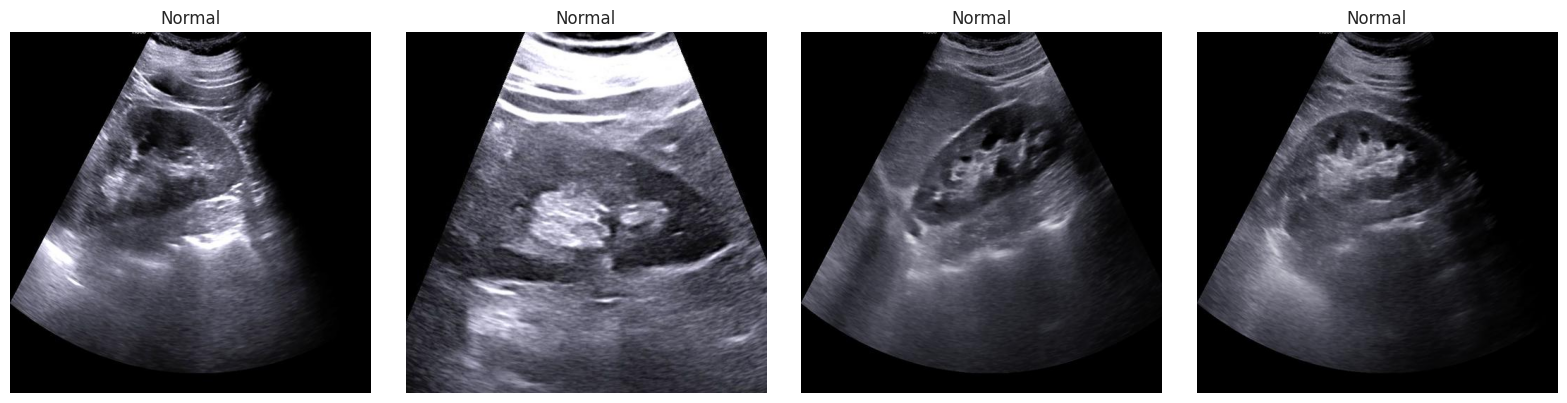

In [4]:
def show_samples(class_name, num=4):
    folder = os.path.join(data_path, class_name)
    files = os.listdir(folder)[:num]
    fig, axes = plt.subplots(1, num, figsize=(16, 4))
    for i, file in enumerate(files):
        img = Image.open(os.path.join(folder, file))
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"{class_name}", fontsize=12)
    plt.tight_layout()
    plt.show()

# Display samples for each class
for cls in classes:
    show_samples(cls)

This set of images displays representative samples from each class in the dataset. Visualizing sample images helps us get a qualitative understanding of the data, including variations in image quality, texture, and features relevant to each class. This step is crucial for familiarizing ourselves with the dataset before diving into model building.

# Analyze Image Sizes (Width & Height)

In [5]:
widths, heights = [], []

for cls in classes:
    for file in tqdm(os.listdir(os.path.join(data_path, cls)), desc=f"Reading {cls}"):
        img_path = os.path.join(data_path, cls, file)
        img = Image.open(img_path)
        widths.append(img.width)
        heights.append(img.height)

Reading Normal: 100%|██████████| 4414/4414 [00:39<00:00, 110.51it/s]


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


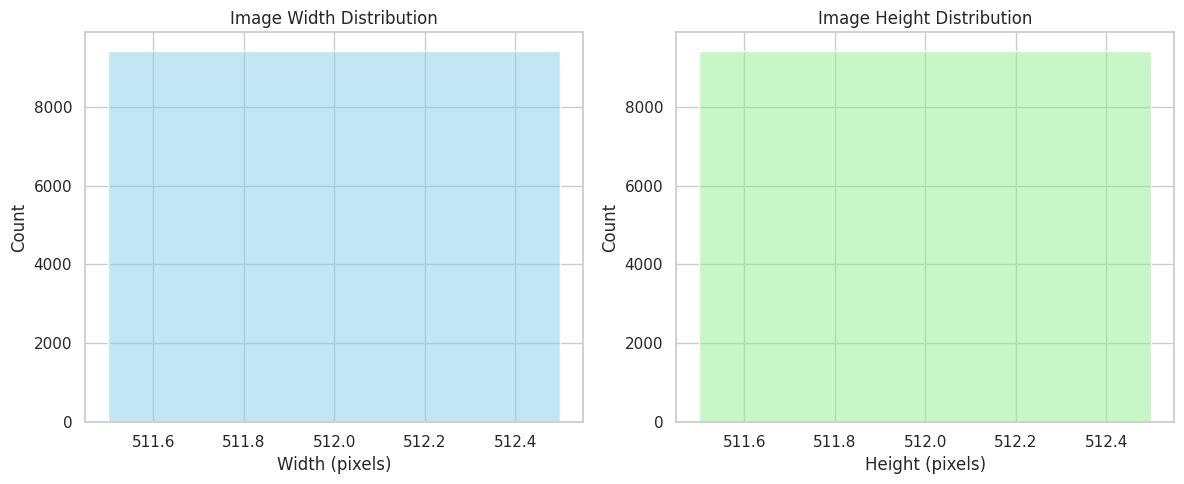

In [6]:
# Plot distributions of image widths and heights
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(widths, ax=ax[0], kde=True, color='skyblue')
ax[0].set_title('Image Width Distribution')
ax[0].set_xlabel('Width (pixels)')

sns.histplot(heights, ax=ax[1], kde=True, color='lightgreen')
ax[1].set_title('Image Height Distribution')
ax[1].set_xlabel('Height (pixels)')

plt.tight_layout()
plt.show()

### Histogram of Image Widths
This histogram illustrates the distribution of image widths in the dataset. It shows how image sizes vary across the dataset, which informs us about the resizing or cropping strategies needed for preprocessing. Consistent image size is important for training convolutional neural networks effectively.

### Histogram of Image Heights
Similar to the width histogram, this plot shows the distribution of image heights. Understanding height variations ensures we can standardize image dimensions properly during data preprocessing.

# Aspect Ratio Analysis (Width / Height)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


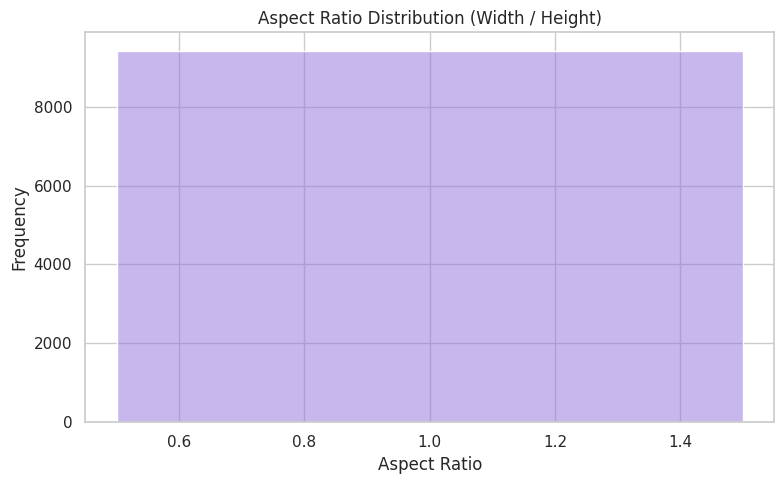

In [7]:
aspect_ratios = [w / h for w, h in zip(widths, heights)]

plt.figure(figsize=(8, 5))
sns.histplot(aspect_ratios, kde=True, color='mediumpurple')
plt.title('Aspect Ratio Distribution (Width / Height)')
plt.xlabel('Aspect Ratio')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

This plot displays the distribution of the aspect ratios (width divided by height) of the images. Aspect ratio analysis helps us identify if images have consistent proportions or if some images are stretched or squished. Maintaining aspect ratios during resizing or augmentation is important to preserve relevant visual features.

# Phase 2: Data Pipeline + Augmentation

# PyTorch Version (DataLoader + Augmentation (using Albumentations))

In [8]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

In [9]:
data_path = "/kaggle/input/kidney-stone-classification-and-object-detection"
classes = sorted(os.listdir(data_path))
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

In [10]:
# Create list of image paths and labels
image_paths, labels = [], []
for cls in classes:
    folder = os.path.join(data_path, cls)
    for img_name in os.listdir(folder):
        image_paths.append(os.path.join(folder, img_name))
        labels.append(class_to_idx[cls])

In [11]:
# Stratified split into train, val, test
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.15, stratify=labels, random_state=42)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.1765, stratify=train_labels, random_state=42)

In [12]:
# Define augmentation pipelines with Albumentations
train_transform = A.Compose([
    A.Resize(224, 224),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.HueSaturationValue(p=0.3),
    A.GaussNoise(p=0.1),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

In [13]:
val_test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

In [14]:
# Custom Dataset Class
class KidneyStoneDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = np.array(Image.open(img_path).convert("RGB"))
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image=image)['image']
        return image, label

# Create datasets
train_dataset = KidneyStoneDataset(train_paths, train_labels, transform=train_transform)
val_dataset = KidneyStoneDataset(val_paths, val_labels, transform=val_test_transform)
test_dataset = KidneyStoneDataset(test_paths, test_labels, transform=val_test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

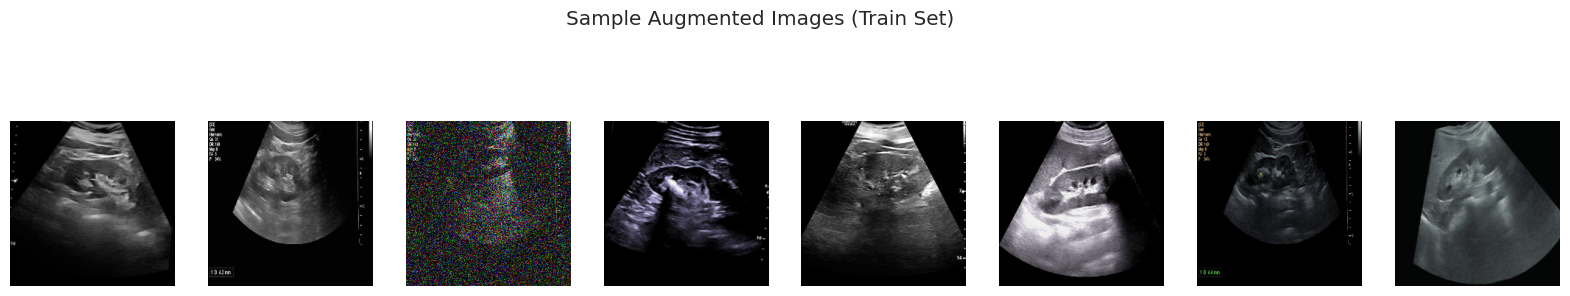

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def denormalize(img_tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

def show_augmented_images(dataloader, n_images=8):
    images, labels = next(iter(dataloader))
    plt.figure(figsize=(20,4))
    for i in range(n_images):
        plt.subplot(1, n_images, i+1)
        plt.imshow(denormalize(images[i]))
        plt.axis('off')
    plt.suptitle("Sample Augmented Images (Train Set)")
    plt.show()

show_augmented_images(train_loader)

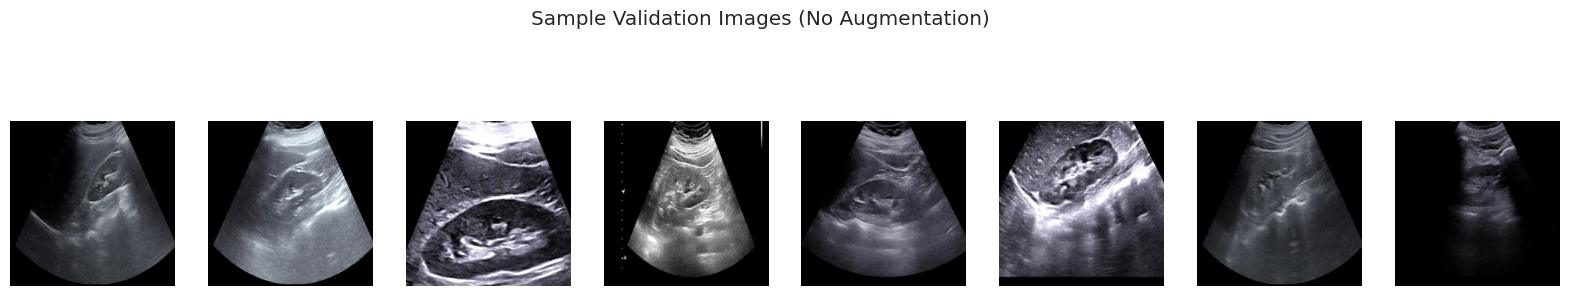

In [16]:
def show_val_images(dataloader, n_images=8):
    images, labels = next(iter(dataloader))
    plt.figure(figsize=(20,4))
    for i in range(n_images):
        plt.subplot(1, n_images, i+1)
        plt.imshow(denormalize(images[i]))
        plt.axis('off')
    plt.suptitle("Sample Validation Images (No Augmentation)")
    plt.show()

show_val_images(val_loader)

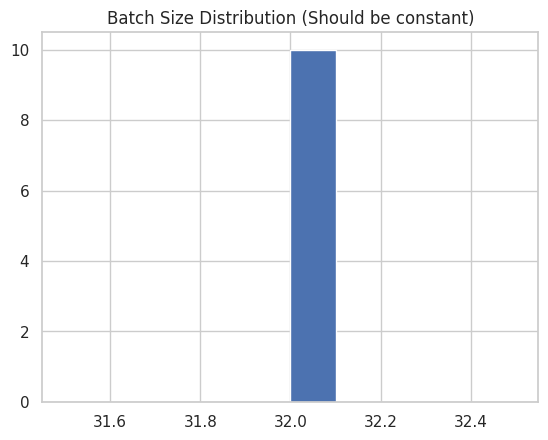

In [17]:
batch_sizes = [len(batch[0]) for batch in [next(iter(train_loader))]*10] 
plt.hist(batch_sizes)
plt.title("Batch Size Distribution (Should be constant)")
plt.show()

In [18]:
# Define custom Dataset class
class KidneyStoneDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        label = self.labels[idx]

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, label

In [19]:
# Create Dataset and DataLoader objects
batch_size = 32

train_dataset = KidneyStoneDataset(train_paths, train_labels, transform=train_transform)
val_dataset = KidneyStoneDataset(val_paths, val_labels, transform=val_test_transform)
test_dataset = KidneyStoneDataset(test_paths, test_labels, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [20]:
# 7. Visualize a batch of augmented images (optional)
import matplotlib.pyplot as plt
import torchvision

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(4, 8, figsize=(15,8))
        images = images.permute(0, 2, 3, 1).cpu().numpy()
        for i in range(min(len(images), 32)):
            r = i // 8
            c = i % 8
            ax[r, c].imshow(images[i])
            ax[r, c].axis('off')
        plt.show()
        break

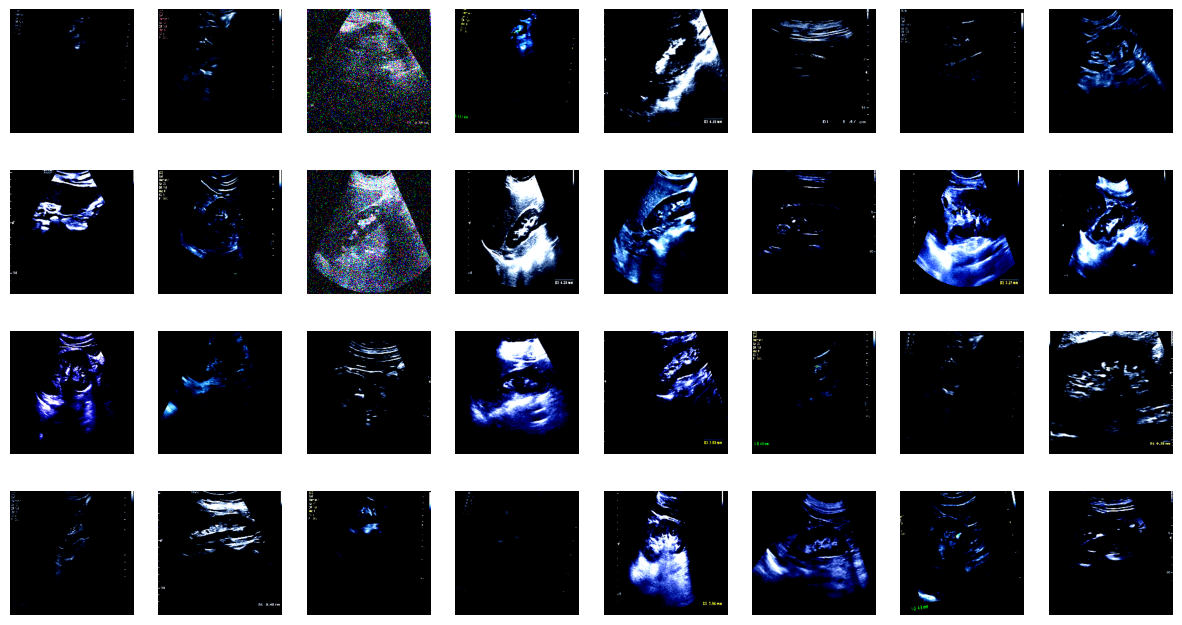

In [21]:
show_batch(train_loader)

# TensorFlow Version (Pipeline + Augmentation)

In [22]:
import os
import tensorflow as tf

2025-07-22 00:24:36.612164: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753143876.807258      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753143876.868694      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [23]:
# Set data path and classes
data_path = "/kaggle/input/kidney-stone-classification-and-object-detection"
classes = sorted(os.listdir(data_path))
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

In [24]:
# Gather image paths and labels
image_paths = []
labels = []

In [25]:
for cls in classes:
    folder = os.path.join(data_path, cls)
    for img_name in os.listdir(folder):
        image_paths.append(os.path.join(folder, img_name))
        labels.append(class_to_idx[cls])

In [26]:
# Stratified split (use sklearn as before)
from sklearn.model_selection import train_test_split
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.15, stratify=labels, random_state=42)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.1765, stratify=train_labels, random_state=42)

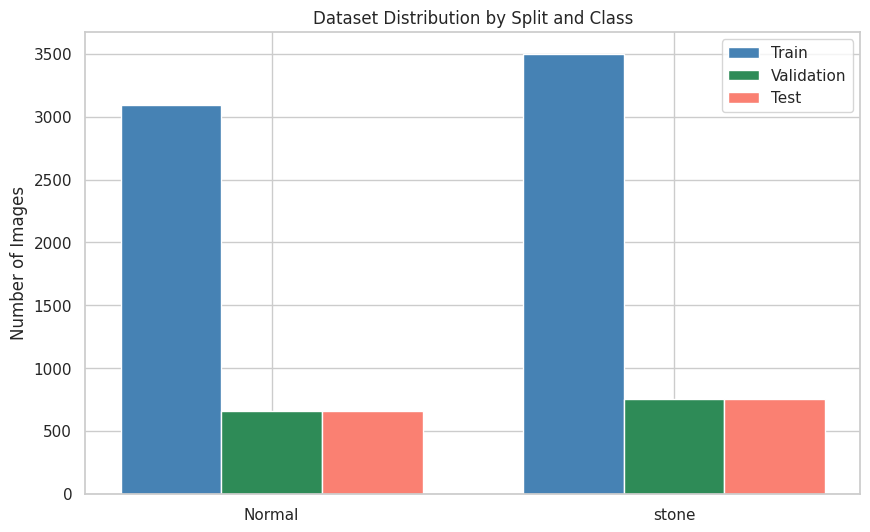

In [27]:
import matplotlib.pyplot as plt

def plot_split_distribution(train_labels, val_labels, test_labels, classes):
    from collections import Counter

    train_counts = Counter(train_labels)
    val_counts = Counter(val_labels)
    test_counts = Counter(test_labels)

    labels = [classes[i] for i in range(len(classes))]
    train_vals = [train_counts[i] for i in range(len(classes))]
    val_vals = [val_counts[i] for i in range(len(classes))]
    test_vals = [test_counts[i] for i in range(len(classes))]

    x = range(len(classes))
    width = 0.25

    plt.figure(figsize=(10,6))
    plt.bar(x, train_vals, width=width, label='Train', color='steelblue')
    plt.bar([i + width for i in x], val_vals, width=width, label='Validation', color='seagreen')
    plt.bar([i + 2*width for i in x], test_vals, width=width, label='Test', color='salmon')

    plt.xticks([i + width for i in x], labels)
    plt.ylabel('Number of Images')
    plt.title('Dataset Distribution by Split and Class')
    plt.legend()
    plt.show()

plot_split_distribution(train_labels, val_labels, test_labels, classes)

In [28]:
# Create tf.data.Dataset objects
def preprocess_image(file_path, label, training=True):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])

    if training:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
        image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
        image = tf.image.random_hue(image, max_delta=0.05)
        # Add noise
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.05)
        image = tf.add(image, noise)
        image = tf.clip_by_value(image, 0.0, 255.0)

    image = image / 255.0  # Normalize to [0,1]
    return image, label

batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.shuffle(buffer_size=1000).map(lambda x, y: preprocess_image(x, y, training=True))
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(lambda x, y: preprocess_image(x, y, training=False))
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_ds = test_ds.map(lambda x, y: preprocess_image(x, y, training=False))
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1753143888.734349      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753143888.735122      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [29]:
def show_batch_tf(dataset):
    plt.figure(figsize=(15,8))
    for images, labels in dataset.take(1):
        for i in range(32):
            ax = plt.subplot(4,8,i+1)
            plt.imshow(images[i].numpy())
            plt.axis("off")
    plt.show()

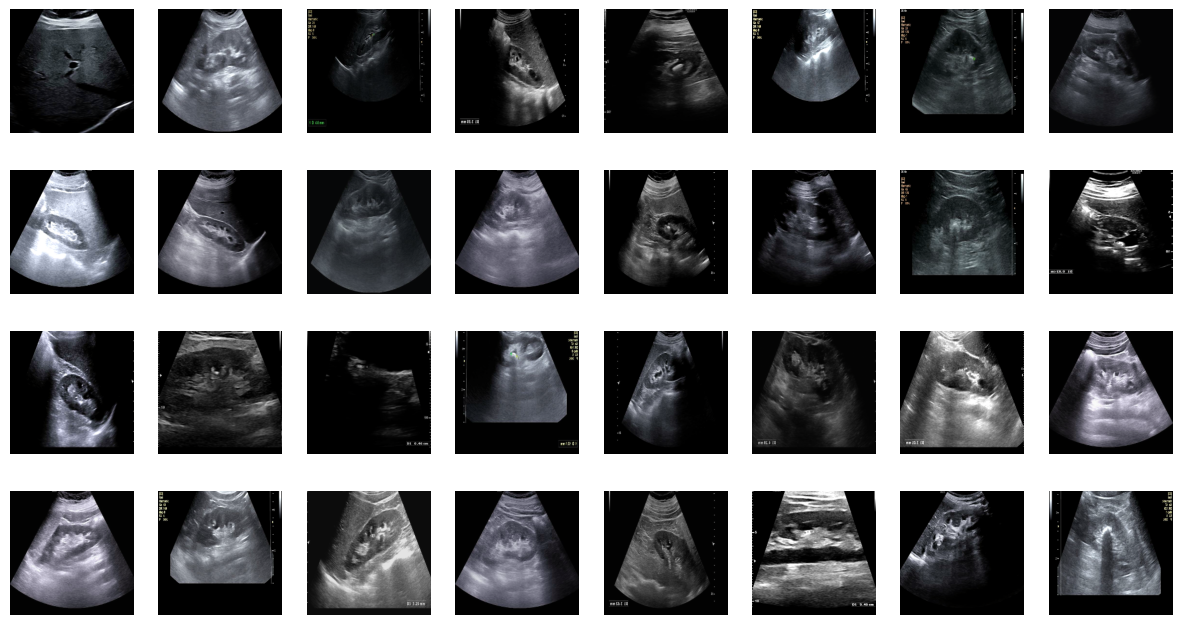

In [30]:
show_batch_tf(train_ds)

# Phase 3: Multi-Model Design & Medical AI Concepts

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [32]:
# Define Custom CNN Model
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # input RGB
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 112x112

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 56x56

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 28x28

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 14x14
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [33]:
# Training and Evaluation Functions
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    conf_mat = confusion_matrix(all_labels, all_preds)
    return epoch_loss, epoch_acc, precision, recall, f1, conf_mat

In [34]:
# Training Loop with Early Stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=25, patience=5):
    best_val_loss = float('inf')
    best_model_wts = None
    epochs_no_improve = 0

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, _, _, _, _ = evaluate(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered")
                break

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accs, val_accs

In [35]:
def plot_confusion_matrix(conf_mat, classes):
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [36]:
# Run Training & Evaluation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(classes)

model = CustomCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 25
patience = 5

trained_model, train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader, criterion, optimizer, device, num_epochs, patience)

Epoch [1/25] - Train Loss: 0.2143, Train Acc: 0.9288 | Val Loss: 0.0047, Val Acc: 0.9979
Epoch [2/25] - Train Loss: 0.0644, Train Acc: 0.9763 | Val Loss: 0.0051, Val Acc: 0.9986
Epoch [3/25] - Train Loss: 0.0428, Train Acc: 0.9854 | Val Loss: 0.0012, Val Acc: 0.9993
Epoch [4/25] - Train Loss: 0.0287, Train Acc: 0.9889 | Val Loss: 0.0015, Val Acc: 1.0000
Epoch [5/25] - Train Loss: 0.0334, Train Acc: 0.9885 | Val Loss: 0.0000, Val Acc: 1.0000
Epoch [6/25] - Train Loss: 0.0236, Train Acc: 0.9907 | Val Loss: 0.0001, Val Acc: 1.0000
Epoch [7/25] - Train Loss: 0.0193, Train Acc: 0.9942 | Val Loss: 0.0005, Val Acc: 1.0000
Epoch [8/25] - Train Loss: 0.0123, Train Acc: 0.9959 | Val Loss: 0.0000, Val Acc: 1.0000
Epoch [9/25] - Train Loss: 0.0153, Train Acc: 0.9936 | Val Loss: 0.0001, Val Acc: 1.0000
Epoch [10/25] - Train Loss: 0.0133, Train Acc: 0.9961 | Val Loss: 0.0000, Val Acc: 1.0000
Epoch [11/25] - Train Loss: 0.0177, Train Acc: 0.9941 | Val Loss: 0.0002, Val Acc: 1.0000
Epoch [12/25] - Tra

In [37]:
# Evaluate on test set
test_loss, test_acc, test_prec, test_rec, test_f1, test_conf_mat = evaluate(
    trained_model, test_loader, criterion, device)

print(f"Test Results - Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, Precision: {test_prec:.4f}, Recall: {test_rec:.4f}, F1-Score: {test_f1:.4f}")

Test Results - Loss: 0.0000, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


In [38]:
def plot_training_curves(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='steelblue')
    plt.plot(epochs, val_losses, label='Validation Loss', color='darkorange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train Accuracy', color='seagreen')
    plt.plot(epochs, val_accs, label='Validation Accuracy', color='crimson')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [39]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

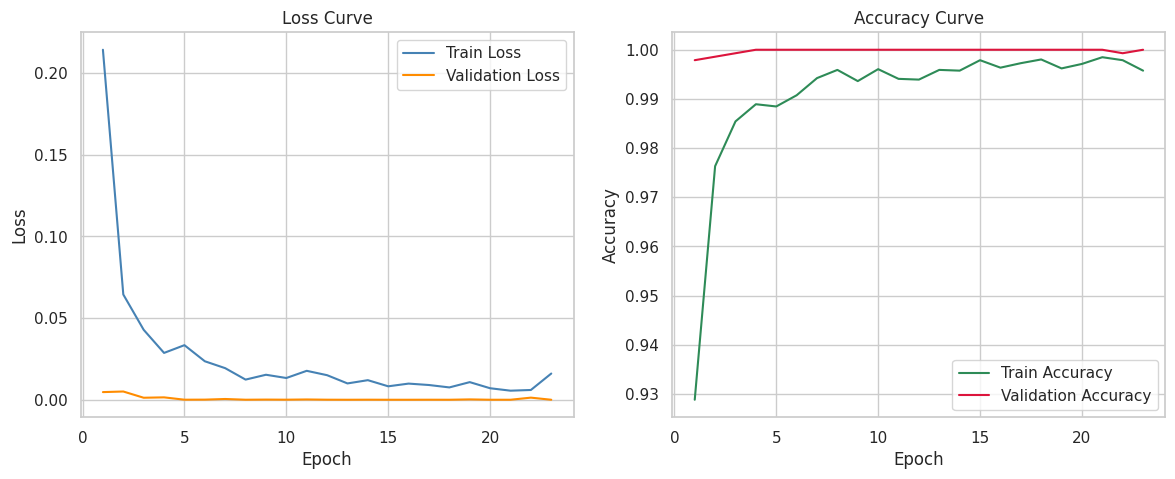

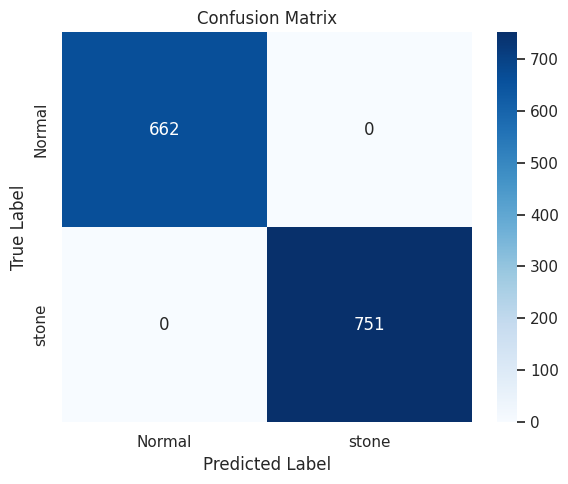

In [40]:
plot_training_curves(train_losses, val_losses, train_accs, val_accs)
plot_confusion_matrix(test_conf_mat, classes)

# Phase 4: Model Evaluation & Visual Analysis

In [41]:
from sklearn.metrics import classification_report, confusion_matrix
import torch

In [42]:
def evaluate_model(model, dataloader, device, class_names):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
            all_probs.extend(probs.cpu().numpy().tolist())

    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)

    return cm, report, all_labels, all_preds, all_probs

In [43]:
class_names = classes  
cm, report, y_true, y_pred, y_probs = evaluate_model(trained_model, test_loader, device, class_names)
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
               precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       662
       stone       1.00      1.00      1.00       751

    accuracy                           1.00      1413
   macro avg       1.00      1.00      1.00      1413
weighted avg       1.00      1.00      1.00      1413



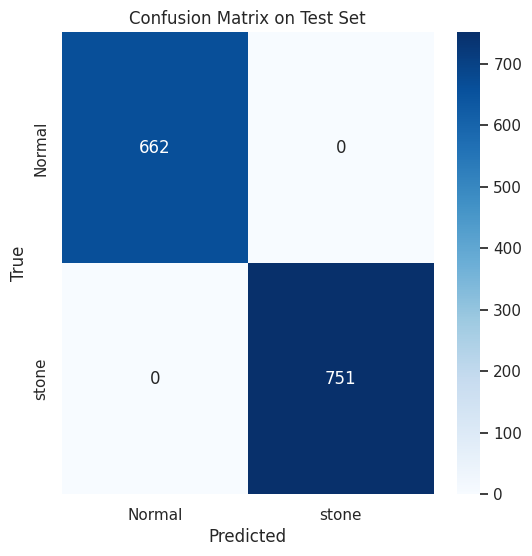

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set')
plt.show()

In [45]:
def show_predictions(dataloader, model, device, class_names, n_samples=8):
    model.eval()
    shown = 0
    plt.figure(figsize=(20,5))
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)

            for img, true, pred in zip(images, labels, preds):
                if shown >= n_samples:
                    plt.show()
                    return
                ax = plt.subplot(1, n_samples, shown + 1)
                img_np = img.permute(1, 2, 0).cpu().numpy()
                ax.imshow(img_np * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406]))
                color = 'green' if true == pred else 'red'
                ax.set_title(f"True: {class_names[true]}\nPred: {class_names[pred]}", color=color)
                ax.axis('off')
                shown += 1

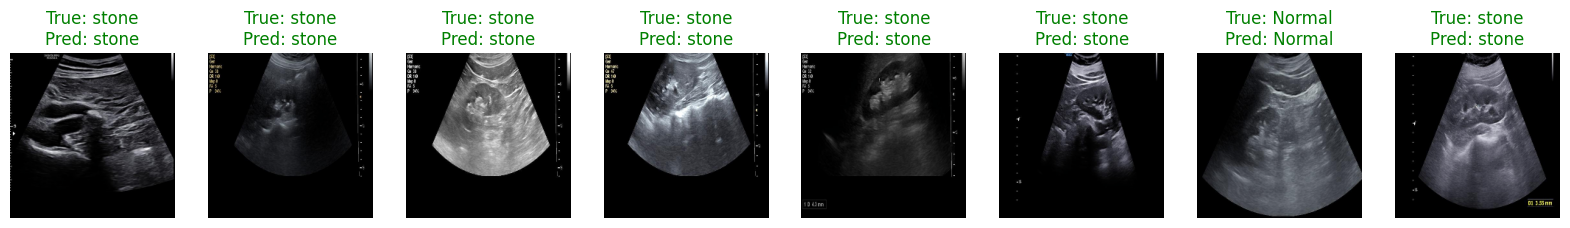

In [46]:
show_predictions(test_loader, trained_model, device, class_names, n_samples=8)

In [47]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

In [48]:
def plot_roc_curves(y_true, y_probs, class_names):
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
    fpr, tpr, roc_auc = {}, {}, {}

    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for All Classes')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [49]:
from sklearn.metrics import accuracy_score
import torch.nn.functional as F

In [50]:
y_true_labels = y_true

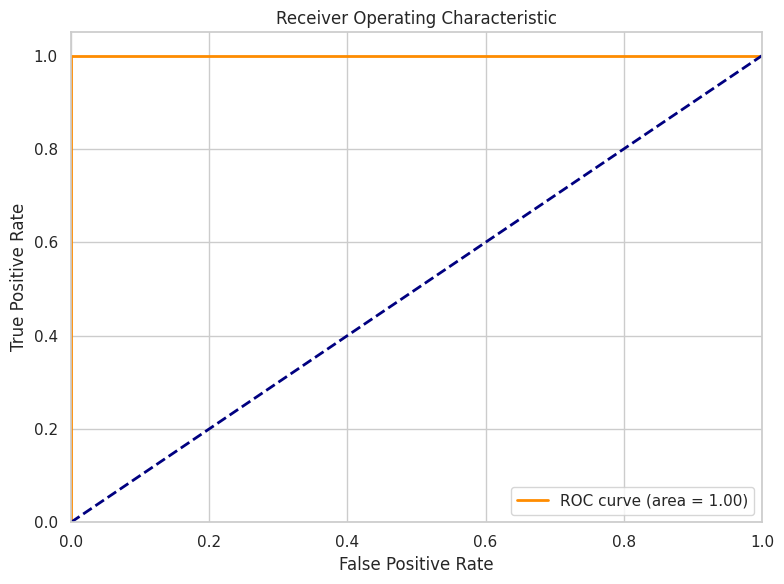

In [51]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_probs = np.array(y_probs)
y_true = np.array(y_true)

if y_probs.ndim == 2 and y_probs.shape[1] == 2:
    probs_class1 = y_probs[:, 1]
else:
    probs_class1 = y_probs  

fpr, tpr, thresholds = roc_curve(y_true, probs_class1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [52]:
from sklearn.metrics import precision_recall_curve, average_precision_score

In [53]:
def plot_precision_recall(y_true, y_probs, class_names):
    if y_probs.ndim == 2 and y_probs.shape[1] == 2:
        probs_class1 = y_probs[:, 1]
    else:
        probs_class1 = y_probs
    
    precision, recall, _ = precision_recall_curve(y_true, probs_class1)
    ap = average_precision_score(y_true, probs_class1)

    plt.figure(figsize=(8,6))
    plt.plot(recall, precision, label=f'AP = {ap:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

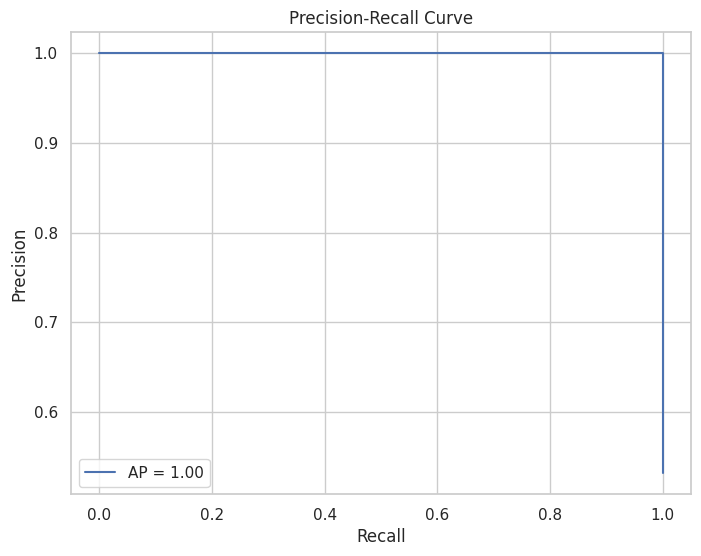

In [54]:
plot_precision_recall(y_true, y_probs, class_names)

# Overfitting OR Data Leakage?!

In [55]:
def analyze_overfitting(train_losses, val_losses, train_accs, val_accs, patience=5, threshold=0.01):
    """
    Draw learning curves and provide simple overfitting analysis.
    
    Args:
        train_losses (list of float): Training losses per epoch
        val_losses (list of float): Validation losses per epoch
        train_accs (list of float): Training accuracies per epoch
        val_accs (list of float): Validation accuracies per epoch
        patience (int): Number of epochs for early stopping patience (optional)
        threshold (float): Threshold for detecting overfitting in loss or accuracy difference
    
    Returns:
        None, just plots and prints analysis.
    """
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(14,5))

    # Loss plot
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1,2,2)
    plt.plot(epochs, train_accs, 'b-', label='Train Accuracy')
    plt.plot(epochs, val_accs, 'r-', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Simple overfitting heuristic
    final_train_loss = train_losses[-1]
    final_val_loss = val_losses[-1]
    final_train_acc = train_accs[-1]
    final_val_acc = val_accs[-1]

    loss_diff = final_val_loss - final_train_loss
    acc_diff = final_train_acc - final_val_acc

    print(f"Final Train Loss: {final_train_loss:.4f}")
    print(f"Final Validation Loss: {final_val_loss:.4f}")
    print(f"Final Train Accuracy: {final_train_acc:.4f}")
    print(f"Final Validation Accuracy: {final_val_acc:.4f}")

    if loss_diff > threshold and acc_diff > threshold:
        print("\n⚠️ Warning: Signs of overfitting detected!")
        print(f"Validation loss is higher than train loss by {loss_diff:.4f}")
        print(f"Train accuracy is higher than validation accuracy by {acc_diff:.4f}")
    elif loss_diff < 0 and acc_diff < 0:
        print("\nModel might be underfitting or validation set easier than training set.")
    else:
        print("\nNo clear sign of overfitting detected based on loss and accuracy differences.")

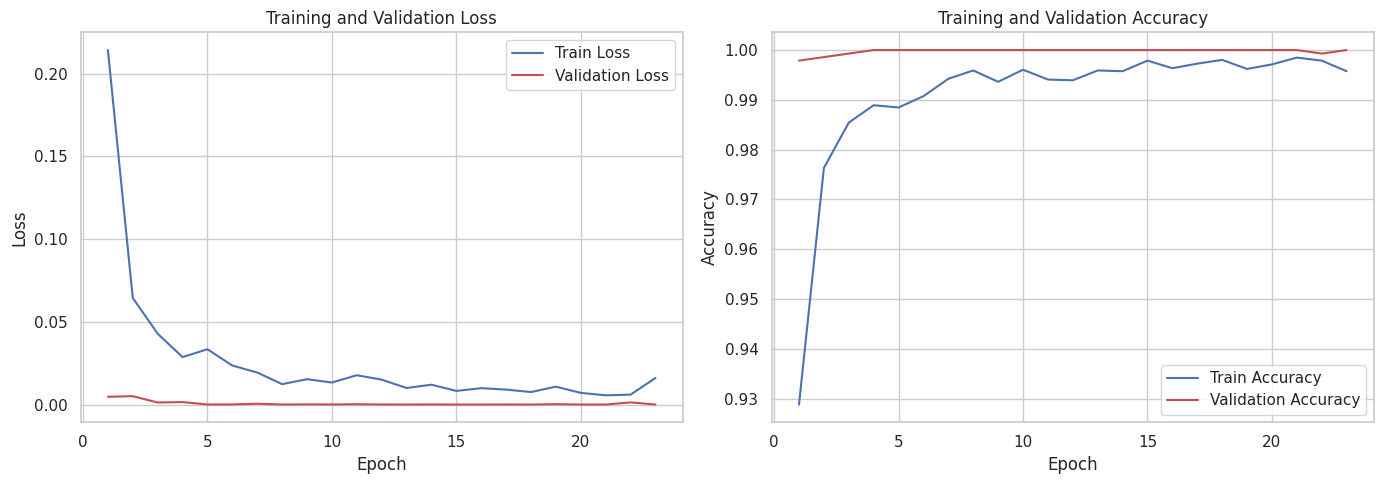

Final Train Loss: 0.0160
Final Validation Loss: 0.0000
Final Train Accuracy: 0.9958
Final Validation Accuracy: 1.0000

Model might be underfitting or validation set easier than training set.


In [56]:
analyze_overfitting(train_losses, val_losses, train_accs, val_accs)

In [57]:
from torchvision import datasets, transforms
from torch.utils.data import random_split

In [58]:
data_dir = '/kaggle/input/kidney-stone-classification-and-object-detection'

In [59]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [60]:
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

In [61]:
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

In [62]:
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

In [63]:
# DataLoaders
from torch.utils.data import DataLoader

In [64]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [65]:
import tensorflow as tf

data_dir = '/kaggle/input/kidney-stone-classification-and-object-detection'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(224, 224),
    batch_size=32
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(224, 224),
    batch_size=32
)

Found 9416 files belonging to 2 classes.
Using 7533 files for training.
Found 9416 files belonging to 2 classes.
Using 1883 files for validation.


In [66]:
import os

base_path = "/kaggle/input/kidney-stone-classification-and-object-detection"
normal_count = len(os.listdir(os.path.join(base_path, "Normal")))
stone_count = len(os.listdir(os.path.join(base_path, "stone")))

print(f"Normal: {normal_count}, Stone: {stone_count}")

Normal: 4414, Stone: 5002


In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [68]:
num_classes = len(classes)
model = CustomCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 25

In [69]:
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []

In [70]:
def evaluate(loader):
    model.eval()
    correct, total, loss_sum = 0, 0, 0
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            loss = criterion(outputs, labels)
            loss_sum += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    accuracy = correct / total
    avg_loss = loss_sum / len(loader)
    return avg_loss, accuracy, np.array(all_labels), np.array(all_probs)

In [75]:
# num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    val_loss, val_acc, val_y_true, val_y_prob = evaluate(val_loader)

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch [1/2] Train Loss: 0.0000, Train Acc: 1.0000 | Val Loss: 0.0000, Val Acc: 1.0000
Epoch [2/2] Train Loss: 0.0000, Train Acc: 1.0000 | Val Loss: 0.0000, Val Acc: 1.0000


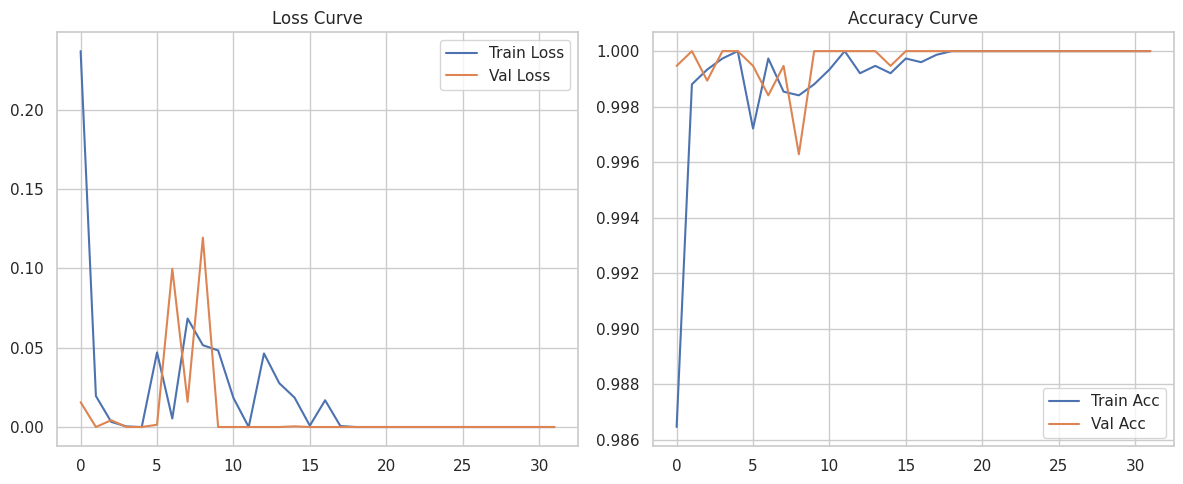

In [76]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.title("Loss Curve")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Acc')
plt.plot(val_acc_list, label='Val Acc')
plt.title("Accuracy Curve")
plt.legend()
plt.tight_layout()
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       889
           1       1.00      1.00      1.00       995

    accuracy                           1.00      1884
   macro avg       1.00      1.00      1.00      1884
weighted avg       1.00      1.00      1.00      1884



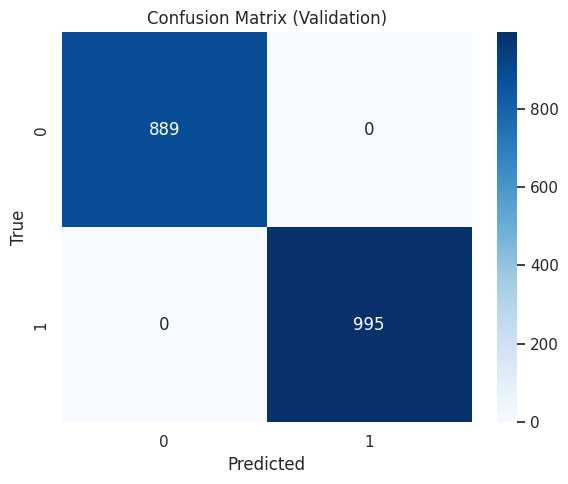

In [77]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

val_preds = np.argmax(val_y_prob, axis=1)

print("\nClassification Report:")
print(classification_report(val_y_true, val_preds))

cm = confusion_matrix(val_y_true, val_preds)
class_labels = np.unique(val_y_true)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Validation)')
plt.tight_layout()
plt.show()

In [78]:
from sklearn.preprocessing import label_binarize

In [79]:
import torch
import numpy as np
import torch.nn.functional as F

model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)  
        all_probs.append(probs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

y_prob = np.concatenate(all_probs)
y_true = np.concatenate(all_labels)

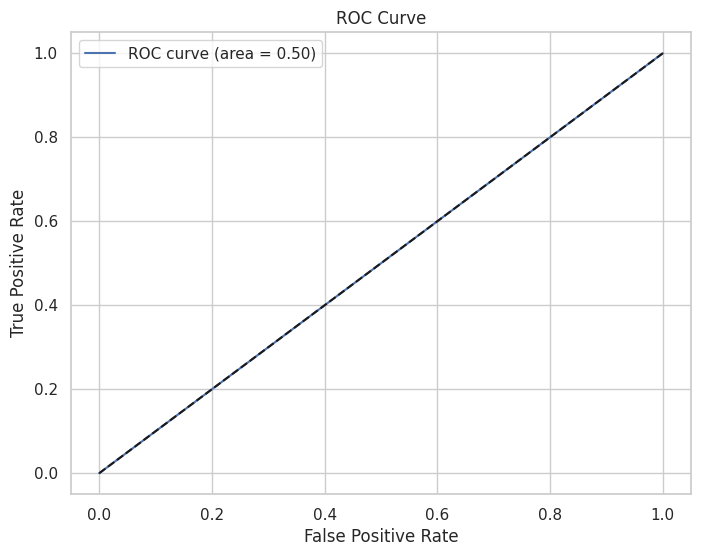

In [80]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_true, y_prob[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Object Detection of Kidney Stones

In [81]:
!pip install -q ultralytics
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.6 MB/s eta 0:00:00:00:0100:01
Creating new Ultra

In [84]:
yaml_content = """
train: /kaggle/input/kidney-stone-images/train/images
val: /kaggle/input/kidney-stone-images/valid/images

nc: 1
names: ['stone']
"""

with open("data.yaml", "w") as f:
    f.write(yaml_content)

In [85]:
model = YOLO('yolov8n.pt') 

model.train(
    data='/kaggle/input/kidney-stone-images/data.yaml',
    epochs=50,
    imgsz=640,
    batch=16,
    name='kidney_stone_detector'
)

100%|██████████| 6.25M/6.25M [00:00<00:00, 81.5MB/s]


Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/input/kidney-stone-images/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=kidney_stone_detector, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, pl

100%|██████████| 755k/755k [00:00<00:00, 15.9MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 65.8MB/s]
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:272: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:281: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::C

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2.7±0.3 MB/s, size: 15.6 KB)


train: Scanning /kaggle/input/kidney-stone-images/train/labels... 1054 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1054/1054 [00:05<00:00, 179.30it/s]


WARNING ⚠️ train: Cache directory /kaggle/input/kidney-stone-images/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2.7±0.8 MB/s, size: 17.3 KB)


val: Scanning /kaggle/input/kidney-stone-images/valid/labels... 123 images, 0 backgrounds, 0 corrupt: 100%|██████████| 123/123 [00:00<00:00, 182.27it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/kidney-stone-images/valid is not writeable, cache not saved.


Plotting labels to runs/detect/kidney_stone_detector/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/kidney_stone_detector
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       1/50      2.52G      2.297      3.334      1.263         34        640: 100%|██████████| 66/66 [00:12<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325    0.00423       0.48      0.136     0.0455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       2/50      2.54G      2.171      2.073      1.251         53        640: 100%|██████████| 66/66 [00:10<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.639      0.508      0.491      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       3/50      2.56G      2.183      1.738        1.3         46        640: 100%|██████████| 66/66 [00:10<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.689      0.457      0.468      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       4/50      2.57G      2.143      1.511      1.268         48        640: 100%|██████████| 66/66 [00:10<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.607      0.471        0.5      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       5/50      2.59G      2.116       1.29      1.273         53        640: 100%|██████████| 66/66 [00:10<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.664      0.415      0.458      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       6/50      2.61G      2.099      1.253      1.271         49        640: 100%|██████████| 66/66 [00:10<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.755      0.551      0.584      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       7/50      2.62G      2.071      1.178      1.233         50        640: 100%|██████████| 66/66 [00:10<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.679      0.551      0.587      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       8/50      2.64G       2.05      1.149      1.222         56        640: 100%|██████████| 66/66 [00:10<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.749      0.649      0.674      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       9/50      2.66G      2.044      1.097      1.226         49        640: 100%|██████████| 66/66 [00:10<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.726      0.603      0.616      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      10/50      2.68G       2.02      1.091      1.218         55        640: 100%|██████████| 66/66 [00:10<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.724      0.643      0.667      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      11/50      2.69G       2.05      1.118      1.229         45        640: 100%|██████████| 66/66 [00:10<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.751       0.64      0.633       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      12/50      2.71G      1.994       1.08      1.206         36        640: 100%|██████████| 66/66 [00:10<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.791      0.625       0.64      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      13/50      2.73G       2.06      1.097      1.215         42        640: 100%|██████████| 66/66 [00:10<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325       0.77      0.655      0.673      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      14/50      2.75G      1.983      1.065      1.185         39        640: 100%|██████████| 66/66 [00:10<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.785      0.634      0.647      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      15/50      2.76G      1.989      1.079      1.212         71        640: 100%|██████████| 66/66 [00:10<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.775      0.658      0.659      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      16/50      2.78G      1.984      1.065      1.179         47        640: 100%|██████████| 66/66 [00:10<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.784      0.622      0.674      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      17/50      2.79G      1.964      1.037      1.179         53        640: 100%|██████████| 66/66 [00:10<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.749      0.643      0.652       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      18/50      2.81G      1.926     0.9887      1.155         45        640: 100%|██████████| 66/66 [00:10<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.775      0.615      0.615      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      19/50      2.83G      1.933     0.9829       1.17         55        640: 100%|██████████| 66/66 [00:10<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.777      0.664      0.691       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      20/50      2.85G      1.951      1.004      1.187         42        640: 100%|██████████| 66/66 [00:10<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.767      0.657      0.716      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      21/50      2.86G      1.949      1.008      1.164         67        640: 100%|██████████| 66/66 [00:10<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.767      0.658      0.669      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      22/50      2.88G      1.897     0.9526      1.154         50        640: 100%|██████████| 66/66 [00:10<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.759      0.661      0.684      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      23/50       2.9G      1.905     0.9765       1.15         38        640: 100%|██████████| 66/66 [00:10<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.801      0.679      0.716      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      24/50      2.92G      1.905     0.9535      1.165         64        640: 100%|██████████| 66/66 [00:10<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.773      0.671      0.671      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      25/50      2.93G       1.89     0.9292       1.16         40        640: 100%|██████████| 66/66 [00:10<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.837      0.646      0.701      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      26/50      2.95G      1.888     0.9539      1.155         23        640: 100%|██████████| 66/66 [00:10<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.802      0.668        0.7      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      27/50      2.96G       1.86     0.9412       1.14         31        640: 100%|██████████| 66/66 [00:10<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.776      0.615      0.607      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      28/50      2.98G      1.865     0.9147      1.135         44        640: 100%|██████████| 66/66 [00:10<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.747      0.686      0.725      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      29/50         3G      1.811     0.9034      1.122         40        640: 100%|██████████| 66/66 [00:10<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.826      0.698      0.725      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      30/50      3.02G      1.843     0.9128      1.126         37        640: 100%|██████████| 66/66 [00:10<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.761      0.686      0.733      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      31/50      3.03G      1.822     0.8942       1.13         42        640: 100%|██████████| 66/66 [00:10<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325       0.79      0.658      0.667      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      32/50      3.05G      1.829     0.8985      1.121         66        640: 100%|██████████| 66/66 [00:10<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.769      0.665      0.713      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      33/50      3.07G      1.857     0.8967      1.128         47        640: 100%|██████████| 66/66 [00:10<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.787      0.659       0.72      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      34/50      3.09G      1.777     0.8839      1.104         38        640: 100%|██████████| 66/66 [00:10<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.763      0.686      0.729        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      35/50       3.1G      1.769     0.8568       1.12         28        640: 100%|██████████| 66/66 [00:10<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.803      0.688      0.737      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      36/50      3.12G      1.775     0.8377      1.116         52        640: 100%|██████████| 66/66 [00:10<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325        0.8      0.689       0.72      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      37/50      3.13G      1.783     0.8495      1.115         54        640: 100%|██████████| 66/66 [00:10<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.805      0.692      0.742      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      38/50      3.15G       1.76     0.8466      1.097         33        640: 100%|██████████| 66/66 [00:10<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.792      0.658      0.703       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      39/50      3.17G      1.772     0.8383      1.108         39        640: 100%|██████████| 66/66 [00:10<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.803      0.664      0.714      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      40/50      3.19G      1.785     0.8517      1.117         52        640: 100%|██████████| 66/66 [00:10<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.765      0.661      0.673      0.255


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      41/50       3.2G      1.771     0.8338      1.124         20        640: 100%|██████████| 66/66 [00:11<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.809      0.695      0.742      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      42/50      3.22G      1.735      0.826      1.112         28        640: 100%|██████████| 66/66 [00:10<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.814        0.7      0.746      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      43/50      3.24G      1.718     0.8099      1.108         31        640: 100%|██████████| 66/66 [00:10<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.795      0.702      0.729      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      44/50      3.26G      1.689     0.7944      1.105         27        640: 100%|██████████| 66/66 [00:10<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.823      0.702      0.738      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      45/50      3.27G      1.698      0.798      1.103         26        640: 100%|██████████| 66/66 [00:10<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.821      0.693      0.736      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      46/50      3.29G       1.65       0.77      1.083         30        640: 100%|██████████| 66/66 [00:10<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.802      0.684      0.721      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      47/50      3.31G      1.683     0.7777      1.095         33        640: 100%|██████████| 66/66 [00:10<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.808      0.687      0.753      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      48/50      3.33G      1.659     0.7629       1.08         20        640: 100%|██████████| 66/66 [00:10<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.802      0.683      0.737        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      49/50      3.34G      1.638     0.7567      1.077         28        640: 100%|██████████| 66/66 [00:10<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.811      0.698      0.749        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      50/50      3.36G      1.625     0.7596      1.076         23        640: 100%|██████████| 66/66 [00:10<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R

                   all        123        325      0.792      0.711      0.747      0.307



50 epochs completed in 0.157 hours.
Optimizer stripped from runs/detect/kidney_stone_detector/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/kidney_stone_detector/weights/best.pt, 6.2MB

Validating runs/detect/kidney_stone_detector/weights/best.pt...
Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:272: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:281: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this o

                   all        123        325      0.813      0.697      0.746      0.318
Speed: 0.2ms preprocess, 1.7ms inference, 0.0ms loss, 5.5ms postprocess per image
Results saved to runs/detect/kidney_stone_detector


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e222ef79dd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [86]:
metrics = model.val()
print(metrics)

Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 13.1±2.3 MB/s, size: 17.2 KB)


val: Scanning /kaggle/input/kidney-stone-images/valid/labels... 123 images, 0 backgrounds, 0 corrupt: 100%|██████████| 123/123 [00:00<00:00, 542.98it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/kidney-stone-images/valid is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.00it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        123        325      0.808      0.692      0.746      0.317
Speed: 1.8ms preprocess, 5.1ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs/detect/kidney_stone_detector2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e21515e1b90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.

In [87]:
results = model.predict(source="/kaggle/input/kidney-stone-images/test/images", save=True, conf=0.25)

import matplotlib.pyplot as plt
import cv2
import glob

pred_imgs = glob.glob('runs/detect/kidney_stone_detector/predict/*.jpg')[:5]
for img_path in pred_imgs:
    img = cv2.imread(img_path)[..., ::-1]
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Detection Result")
    plt.show()


image 1/123 /kaggle/input/kidney-stone-images/test/images/1-3-46-670589-33-1-63703718086120120200001-5487554579919763006_png_jpg.rf.9fd67251e99a47dbe83a5db6efe6c016.jpg: 544x640 3 Tas_Vars, 44.6ms
image 2/123 /kaggle/input/kidney-stone-images/test/images/1-3-46-670589-33-1-63705534438365105500001-5275982036206127404_png_jpg.rf.365c4daf2b772012fe47e07b9daec86e.jpg: 544x640 3 Tas_Vars, 7.1ms
image 3/123 /kaggle/input/kidney-stone-images/test/images/1-3-46-670589-33-1-63705540012666937300001-5673688970564737961_png_jpg.rf.15cca2fecc5f56865de3eb405476b90d.jpg: 544x640 1 Tas_Var, 7.0ms
image 4/123 /kaggle/input/kidney-stone-images/test/images/1-3-46-670589-33-1-63705542123217653900001-5305208767418446842_png_jpg.rf.d6f32a0ac819e4f2a870edfc1ce8079b.jpg: 544x640 3 Tas_Vars, 7.1ms
image 5/123 /kaggle/input/kidney-stone-images/test/images/1-3-46-670589-33-1-63705542123253656000001-4874858110489948158_png_jpg.rf.d79767eb8378783858ea648a8852c859.jpg: 544x640 1 Tas_Var, 7.1ms
image 6/123 /kaggle/

In [88]:
model.predict(source="/kaggle/input/kidney-stone-images/test/images", save=True)


image 1/123 /kaggle/input/kidney-stone-images/test/images/1-3-46-670589-33-1-63703718086120120200001-5487554579919763006_png_jpg.rf.9fd67251e99a47dbe83a5db6efe6c016.jpg: 544x640 3 Tas_Vars, 8.2ms
image 2/123 /kaggle/input/kidney-stone-images/test/images/1-3-46-670589-33-1-63705534438365105500001-5275982036206127404_png_jpg.rf.365c4daf2b772012fe47e07b9daec86e.jpg: 544x640 3 Tas_Vars, 7.8ms
image 3/123 /kaggle/input/kidney-stone-images/test/images/1-3-46-670589-33-1-63705540012666937300001-5673688970564737961_png_jpg.rf.15cca2fecc5f56865de3eb405476b90d.jpg: 544x640 1 Tas_Var, 7.1ms
image 4/123 /kaggle/input/kidney-stone-images/test/images/1-3-46-670589-33-1-63705542123217653900001-5305208767418446842_png_jpg.rf.d6f32a0ac819e4f2a870edfc1ce8079b.jpg: 544x640 3 Tas_Vars, 7.1ms
image 5/123 /kaggle/input/kidney-stone-images/test/images/1-3-46-670589-33-1-63705542123253656000001-4874858110489948158_png_jpg.rf.d79767eb8378783858ea648a8852c859.jpg: 544x640 1 Tas_Var, 7.7ms
image 6/123 /kaggle/i

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Tas_Var'}
 obb: None
 orig_img: array([[[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [108, 108, 108],
         [104, 104, 104],
         [107, 107, 107]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [111, 111, 111],
         [106, 106, 106],
         [114, 114, 114]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [117, 117, 117],
         [108, 108, 108],
         [124, 124, 124]],
 
        ...,
 
        [[  1,   1,   1],
         [  1,   1,   1],
         [  1,   1,   1],
         ...,
         [133, 133, 133],
         [134, 134, 134],
         [134, 134, 134]],
 
        [[  1,   1,   1],
         [  1,   1,   1],
         [  1,   1,   1],
         ...,
         [133, 13

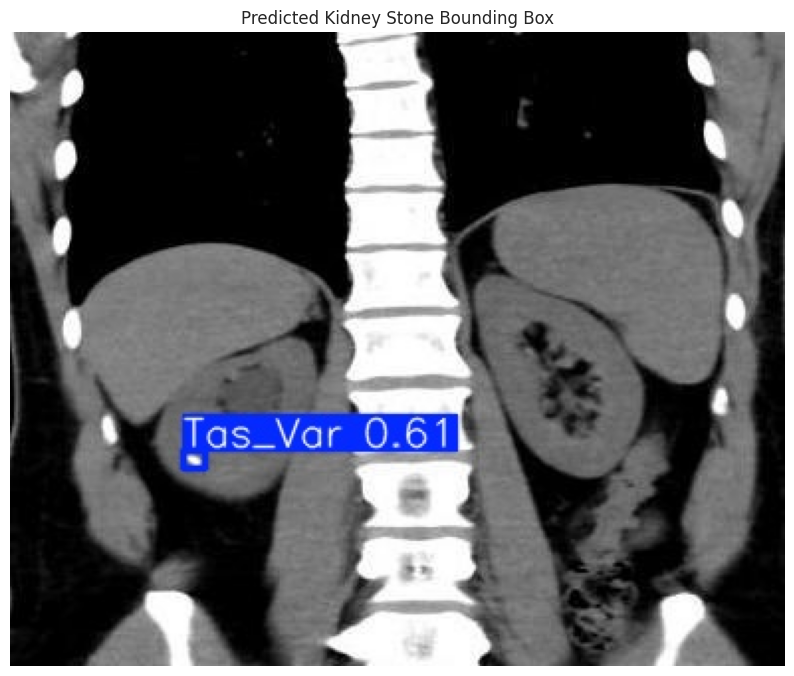

In [89]:
import cv2
import matplotlib.pyplot as plt

img_path = 'runs/detect/kidney_stone_detector4/1-3-46-670589-33-1-63743022347069487300001-5100284836990062688_png_jpg.rf.a63070c6a45f65acabf6e15dbb645a92.jpg'

img = cv2.imread(img_path)[..., ::-1]
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.title("Predicted Kidney Stone Bounding Box")
plt.show()

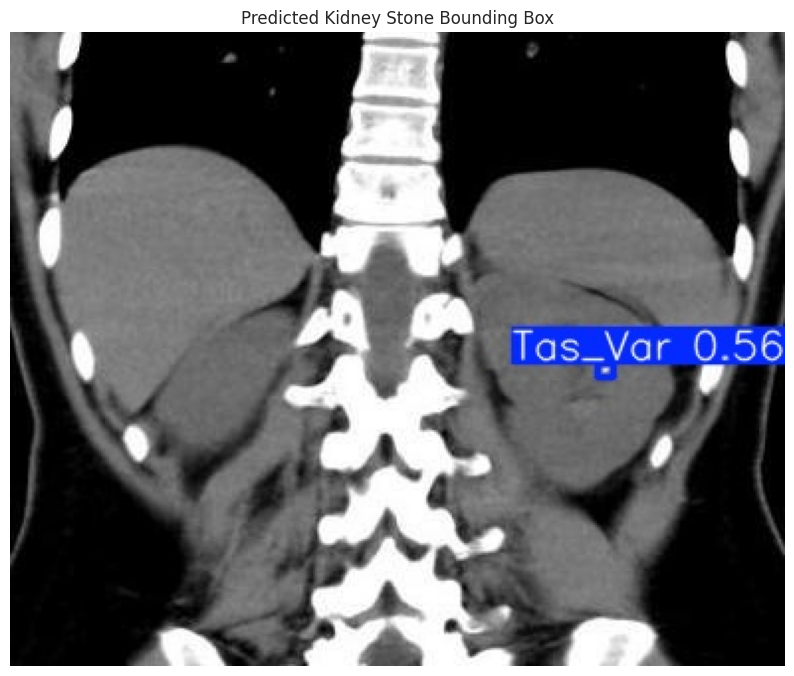

In [90]:
import cv2
import matplotlib.pyplot as plt

img_path = '/kaggle/working/runs/detect/kidney_stone_detector4/1-3-46-670589-33-1-63715282588697485900001-4980671363637353986_png_jpg.rf.942e6d1d8c91713ebd262b0d50ebc83b.jpg'

img = cv2.imread(img_path)[..., ::-1]
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.title("Predicted Kidney Stone Bounding Box")
plt.show()

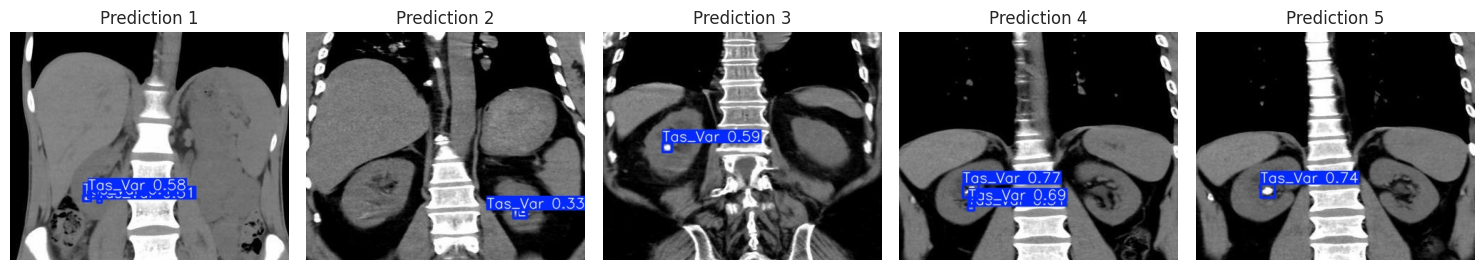

In [91]:
import os
import cv2
import matplotlib.pyplot as plt
from glob import glob

output_dir = 'runs/detect/kidney_stone_detector4'

predicted_images = sorted(glob(f"{output_dir}/*.jpg"))

n = min(5, len(predicted_images))
plt.figure(figsize=(15, 15))

for i in range(n):
    img = cv2.imread(predicted_images[i])[..., ::-1]
    plt.subplot(1, n, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction {i+1}")

plt.tight_layout()
plt.show()